# AlexNet implementation (with PyTorch)
Model from: https://pytorch.org/hub/pytorch_vision_alexnet/

Training loop from: https://kushaj.medium.com/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

## Import required modules

In [1]:
import torch
from torch import nn, optim
from copy import deepcopy
from PIL import Image
from torchvision import transforms
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Get model

### Get pretrained model from source

In [2]:
alexnet = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
alexnet.eval()

Using cache found in /home/wrosales/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Data transformation

Set number of classifications labels

In [3]:
num_labels = 4 # CNV, DME, DRUSEN, NORMAL
labels_list = ["CNV", "DME", "DRUSEN", "NORMAL"]

#### Create train and test sets

In [4]:
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

data_dir = '/volume/OCT/OCT2017/'
sets = ["train", "val", "test"]

size = 224 # given by alexnet
batch_size = 32 # prefered by alexnet

# num_workers = 8 # only if multi-processing is needed

data_transforms = {
    set_type: transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) for set_type in sets
}

image_datasets = {
    set_type : ImageFolder(data_dir + set_type, transform=data_transforms[set_type])
    for set_type in sets
}

data_loader = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=batch_size,
                                   shuffle=True,
                                   pin_memory=True) for x in sets
}

Sets shape

In [5]:
for set_type in sets:
    print(f"Set: {set_type}. Images: {len(data_loader[set_type].dataset.imgs)}")

Set: train. Images: 83484
Set: val. Images: 32
Set: test. Images: 968


Check labels and images

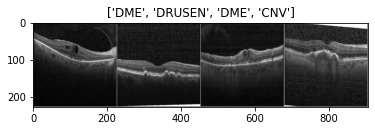

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

images, labels = next(iter(data_loader['val']))
grid_img = make_grid(images[:4], nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[:4]])

## LIMO model

### Modify architecture

In [7]:
def newAlexNet(num_labels):
    newAlexnet = deepcopy(alexnet)
    lastLayer = newAlexnet.classifier[-1] # get usual last layer
    newAlexnet.classifier[-1] = nn.Linear(lastLayer.in_features, num_labels) # modify last layer number of outputs (labels to be classified)
    return newAlexnet

limoAlexnet = newAlexNet(num_labels)

####  Testing model and training loop over validation set only

In [8]:
inputs, labels = next(iter(data_loader['val']))
inputs = inputs.to(device)
labels = labels.to(device)
valNet = newAlexNet(num_labels)
criterion_check1 = nn.CrossEntropyLoss()
optimizer_check1 = optim.SGD(valNet.parameters(), lr=0.001, momentum=0.9)

In [9]:
valNet.train()
epochs = 40
for epoch in range(epochs):
    optimizer_check1.zero_grad()
    outputs = valNet(inputs)
    loss = criterion_check1(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer_check1.step()
    
    if epoch%10 == 0 or epoch == epochs-1:
        print('Epoch {}: Loss = {} Accuracy = {}'.format(epoch+1, loss.item(), torch.sum(preds == labels) / len(labels)))

Epoch 1: Loss = 1.5086668729782104 Accuracy = 0.28125
Epoch 11: Loss = 0.39557400345802307 Accuracy = 0.96875
Epoch 21: Loss = 0.07941702753305435 Accuracy = 0.96875
Epoch 31: Loss = 0.009939725510776043 Accuracy = 1.0
Epoch 40: Loss = 0.005524064879864454 Accuracy = 1.0
